In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
tickers = [
    "ENI.MI", "ISP.MI", "UCG.MI", "SRG.MI", "PST.MI", 
    "PRY.MI", "G.MI", "RACE.MI", "ENEL.MI", 
    "TEN.MI", "MONC.MI", "UNI.MI",
    "FBK.MI", "CPR.MI", "INW.MI", "BAMI.MI", "BMED.MI",
    "BPE.MI",  "AMP.MI", "BMPS.MI", "A2A.MI",
    "BC.MI", "DIA.MI", "HER.MI", "TIT.MI", 
    "SPM.MI", "IP.MI", "MB.MI"
]
index_ticker = "FTSEMIB.MI"
data = yf.download(tickers, start="2017-01-01", end="2023-01-01")['Open']
volume_data = yf.download(tickers, start="2017-01-01", end="2023-01-01")['Volume']
index_data = yf.download(index_ticker, start="2017-01-01", end="2023-01-01")['Open']

monthly_data = data.resample('ME').first()
monthly_volume_data = volume_data.resample('ME').first()
index_monthly_data = index_data.resample('ME').first()
returns = monthly_data.pct_change().dropna()
index_returns = index_monthly_data.pct_change().dropna()
window_size = 36
n_components = 5

[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  28 of 28 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data.isna().sum().sum()

np.int64(0)

In [4]:
returns.tail()

Ticker,A2A.MI,AMP.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,CPR.MI,DIA.MI,ENEL.MI,...,MONC.MI,PRY.MI,PST.MI,RACE.MI,SPM.MI,SRG.MI,TEN.MI,TIT.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-31,0.035891,0.105190,-0.067828,0.284897,0.043814,-0.224453,-0.129874,0.083400,0.087480,-0.045199,...,0.197026,0.202399,-0.078502,0.188489,-0.678661,-0.014141,0.115954,-0.130837,0.060943,-0.055556
2022-09-30,-0.109916,-0.192549,-0.023062,-0.089938,-0.019136,-0.263529,0.103704,-0.096804,-0.039852,-0.054957,...,-0.089027,-0.024461,-0.033048,-0.069734,-0.142612,-0.036885,0.003685,-0.049097,0.017715,0.014706
2022-10-31,-0.112304,0.027918,0.083842,-0.027789,0.005979,-0.220128,0.052349,-0.075692,-0.127210,-0.095131,...,-0.049545,-0.029363,-0.025316,-0.010932,-0.095456,-0.124468,-0.027166,-0.080370,0.062519,-0.050725
2022-11-30,0.139113,-0.041871,0.160345,0.195652,0.197998,-0.620550,0.205357,0.030404,0.178336,0.082918,...,0.061693,0.133243,0.153247,0.054211,0.578199,0.105711,0.196226,0.057733,0.230903,0.119593
2022-12-31,0.142478,0.076772,0.071197,0.069024,0.056136,-0.020725,0.047619,0.077967,-0.033632,0.134269,...,0.133784,0.011998,0.065315,0.065901,0.033033,0.074945,0.042902,0.046069,0.030083,0.115909


In [5]:
def rolling_pca(returns, window_size, n_components):
    train_factors_list = []
    test_factors_list = []
    test_index_list = []
    loadings_list = []
    for start in range(len(returns) - window_size):
        end = start + window_size
        train_data = returns.iloc[start:end]
        test_data = returns.iloc[end:end+1]
        pca = PCA(n_components=n_components)
        pca.fit(train_data)
        train_factors = pca.transform(train_data)
        test_factors = pca.transform(test_data)
        train_factors_list.append(train_factors)
        test_factors_list.append(test_factors)
        test_index_list.append(test_data.index[0])
        loadings_list.append(pca.components_.T)
    return (np.concatenate(train_factors_list), np.concatenate(test_factors_list),
            np.array(loadings_list), test_index_list)

def factor_model_returns(returns, volume_data, loadings, factors, test_index, transaction_cost_rate, slippage_rate=0.005):
    B_list = []
    specific_returns_list = []
    specific_var_list = []
    all_test_factors = []
    factor_model_portfolio_returns = []
    net_returns_list = []
    previous_weights = np.zeros(returns.shape[1])
    portfolio_value = 1
    for i in range(len(test_index)):
        B = loadings[i]
        test_date = test_index[i]
        test_data = returns.loc[test_date:test_date]
        volume_data_date = volume_data.loc[test_date:test_date]
        factor_returns = factors[i].reshape(1, -1)
        all_test_factors.append(factor_returns)
        specific_returns = test_data.values - np.dot(np.dot(test_data.values, B), B.T)
        gross_returns = test_data.dot(B).dot(factor_returns.T) + specific_returns.sum(axis=1)
        gross_returns_value = gross_returns.iloc[0, 0]
        new_weights = B.dot(factor_returns.T).flatten()
        new_weights /= np.sum(np.abs(new_weights))
        weight_changes = np.abs(new_weights - previous_weights)
        transaction_volume = weight_changes * volume_data_date.values.flatten()
        transaction_costs = transaction_volume * transaction_cost_rate
        slippage_costs = transaction_volume * slippage_rate
        total_transaction_costs = np.sum(transaction_costs + slippage_costs)
        net_returns = gross_returns_value - total_transaction_costs / portfolio_value
        net_returns_list.append(net_returns)
        previous_weights = new_weights
        portfolio_value *= (1 + net_returns)
        factor_model_portfolio_returns.append(net_returns)
        specific_var = np.var(specific_returns, axis=1)
        B_list.append(B)
        specific_returns_list.append(specific_returns)
        specific_var_list.append(specific_var)
    
    all_test_factors = np.concatenate(all_test_factors, axis=0)
    factor_cov_matrix = np.cov(all_test_factors.T)
    
    return B_list, specific_returns_list, factor_cov_matrix, specific_var_list, factor_model_portfolio_returns, net_returns_list

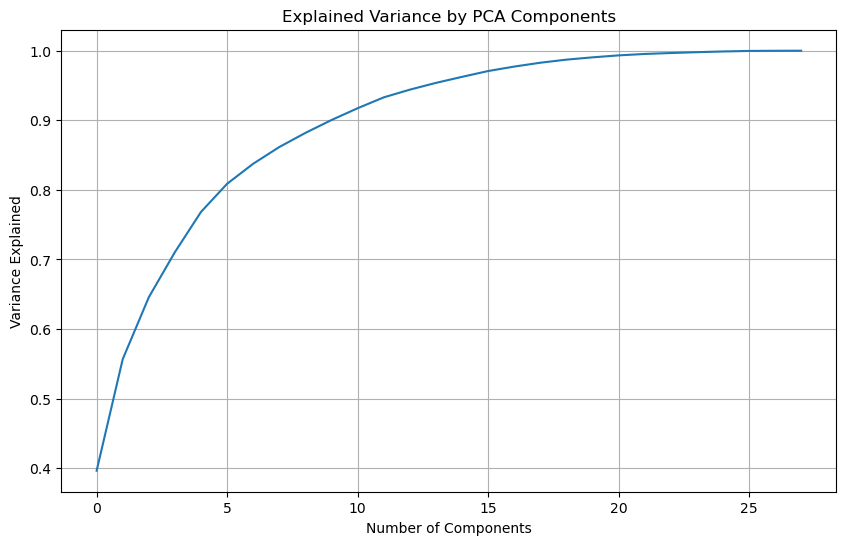

In [6]:
pca = PCA().fit(returns.iloc[:window_size])
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [13]:
transaction_cost_rate = 0
slippage_rate = 0

train_factors, test_factors, loadings, test_index = rolling_pca(returns, window_size, n_components)
B, specific_returns, factor_cov_matrix, specific_var, factor_model_portfolio_returns, net_returns = factor_model_returns(returns, monthly_volume_data, loadings, test_factors, test_index, transaction_cost_rate, slippage_rate)

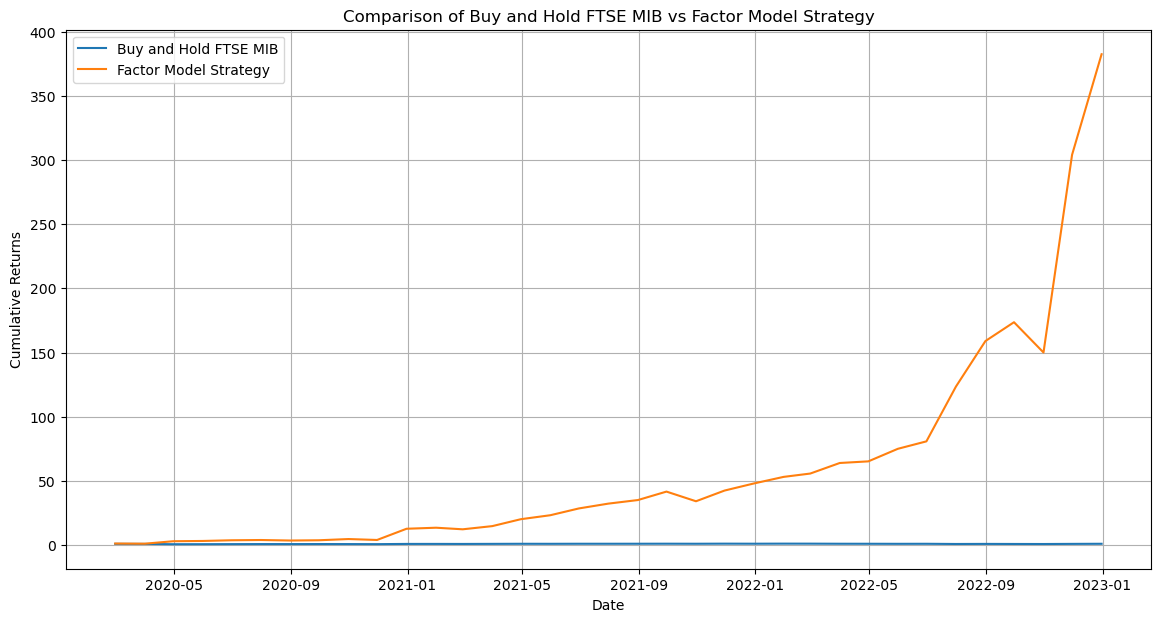

In [14]:
factor_model_portfolio_returns = pd.DataFrame(factor_model_portfolio_returns, index=test_index, columns=["Returns"])
test_start_date = returns.index[window_size]
index_returns_test = index_returns[index_returns.index >= test_start_date]
index_cumulative_returns = (1 + index_returns_test).cumprod()
factor_model_cumulative_returns = (1 + factor_model_portfolio_returns).cumprod()
aligned_index_cumulative_returns = index_cumulative_returns.loc[factor_model_cumulative_returns.index]

plt.figure(figsize=(14, 7))
plt.plot(aligned_index_cumulative_returns, label="Buy and Hold FTSE MIB")
plt.plot(factor_model_cumulative_returns, label="Factor Model Strategy")
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Comparison of Buy and Hold FTSE MIB vs Factor Model Strategy')
plt.legend()
plt.grid(True)
plt.show()